## Notebook Overview

This notebook performs an **Exploratory Data Analysis (EDA)** of the ArASL dataset.  
The main goals are to verify dataset structure, check class balance, identify potential issues, and generate a detailed report.  

Key steps include:  
- Listing all classes and counting images.  
- Visualizing class distribution (bar & pie charts).  
- Checking for corrupted images and unusual file sizes.  
- Displaying random image samples for inspection.  
- Detecting duplicate images using MD5 hashing.  
- Saving results, tables, and figures into `EDA_outputs/` for reference.  

Outcome: The dataset is generally usable, but **class imbalance** and **duplicate images** were identified, which will be handled in the cleaning stage.

In [32]:
from pathlib import Path
import random, json, hashlib
import cv2         #قراءة ومعالجة الصور 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm               #(progress bar)
from IPython.display import Image, display, Markdown  # #يخلني اعرض داخل النوتبوك مباشرة

pd.set_option('display.max_rows', None)  #	يخلي الجداول (DataFrame) تطلع كاملة في النوتبوك وما يختصره


CONFIG

In [33]:
DATA_DIR = Path("/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final")  # ما اقدر ارفع الداتا على القيت هب فغيروا الباث هنا

# Make OUTPUT_DIR absolute so saved files are easy to find
OUTPUT_DIR = (Path().resolve() / "EDA_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   #يعمل إنشاء للمجلد و ما يعطي خطأ لو المجلد موجود اصلا 

# Image extensions we accept
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".gif"}

# Random seed for reproducibility (sampling)
RANDOM_SEED = 42   
random.seed(RANDOM_SEED)   #نضمن إن النتائج تبقى نفسها كل مرة نشغل الكود

# Limit how many images to scan per class for expensive checks (None => all)
SIZE_STATS_LIMIT_PER_CLASS = None  
DUP_SCAN_LIMIT_PER_CLASS   = None  

# Toggle optional visuals
ENABLE_PIE_CHART   = True  #رسم Pie Chart لتوزيع الصور حسب الفئات
ENABLE_SAMPLE_GRID = True  #يعرض Grid (شبكة) فيها عينات من الصور
ENABLE_DUP_CHECK   = True  #يفعل فحص التكرارات

هنا بما انهم نبهوا ع الرسومات سويت داله تعرض الروسومات هنا و تنحفظ في ملف خارجي عشان نوصل لها بسرعه

In [34]:
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))
    
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))

Report logger 

In [35]:
REPORT_PATH = OUTPUT_DIR / "eda_report.md"  #هذا الملف يجمع كل النصوص + الجداول + الصور اللي نطلعها

def report_start(title="ArASL EDA Report"):    #ينشئ ملف التقرير ويكتب فيه العنوان الرئيسي
    REPORT_PATH.write_text(f"# {title}\n\n", encoding="utf-8")  #يبدأ تقرير جديد كل مرة

def report_section(title, text=None):  #يضيف عنوان فرعي 
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        if text:
            f.write(text + "\n")

def _csv_preview_block(df, rows):
    # embed first rows as a code block CSV (avoids tabulate dependency)
    preview = df.head(rows).to_csv(index=False)
    return f"\n**Preview ({min(rows, len(df))} rows)**:\n\n```\n{preview}\n```\n"

def report_table(caption, df: pd.DataFrame, csv_name: str, show_rows=None):
    csv_path = OUTPUT_DIR / csv_name
    df.to_csv(csv_path, index=False)
    if show_rows is None:
        show_rows = len(df)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}** — saved CSV: `{csv_path.name}`\n")
        f.write(_csv_preview_block(df, show_rows))

def report_image(caption, img_path):
    rel = img_path.relative_to(OUTPUT_DIR)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}**\n\n![{caption}]({rel.as_posix()})\n")

def report_kv(title, d: dict):
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        for k,v in d.items():
            f.write(f"- **{k}**: {v}\n")

# start report
report_start("ArASL EDA Report")

 LIST CLASSES

In [36]:
def list_classes(data_dir: Path):
    if not data_dir.exists():
        raise SystemExit(f"[ERROR] Dataset not found at: {data_dir}")
    classes = sorted([d for d in data_dir.iterdir() if d.is_dir()], key=lambda p: p.name)
    (OUTPUT_DIR / "classes.txt").write_text("\n".join([c.name for c in classes]), encoding="utf-8")
    return classes

classes = list_classes(DATA_DIR)
report_section("Classes", f"Found **{len(classes)}** classes. Saved list to `classes.txt`.")
display(classes)

[PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/ain'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/al'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/aleff'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/bb'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/dal'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/dha'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/dhad'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/fa'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/gaaf'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/ghain'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/ha'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/haa'),
 PosixPath('/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final/jeem'),
 PosixPat

 COUNT PER CLASS + BAR CHART

Counting images per class: 100%|██████████| 32/32 [00:00<00:00, 762.85it/s]


,class,count
0,ain,2114
1,al,1343
2,aleff,1672
3,bb,1791
4,dal,1634
5,dha,1723
6,dhad,1670
7,fa,1955
8,gaaf,1705
9,ghain,1977


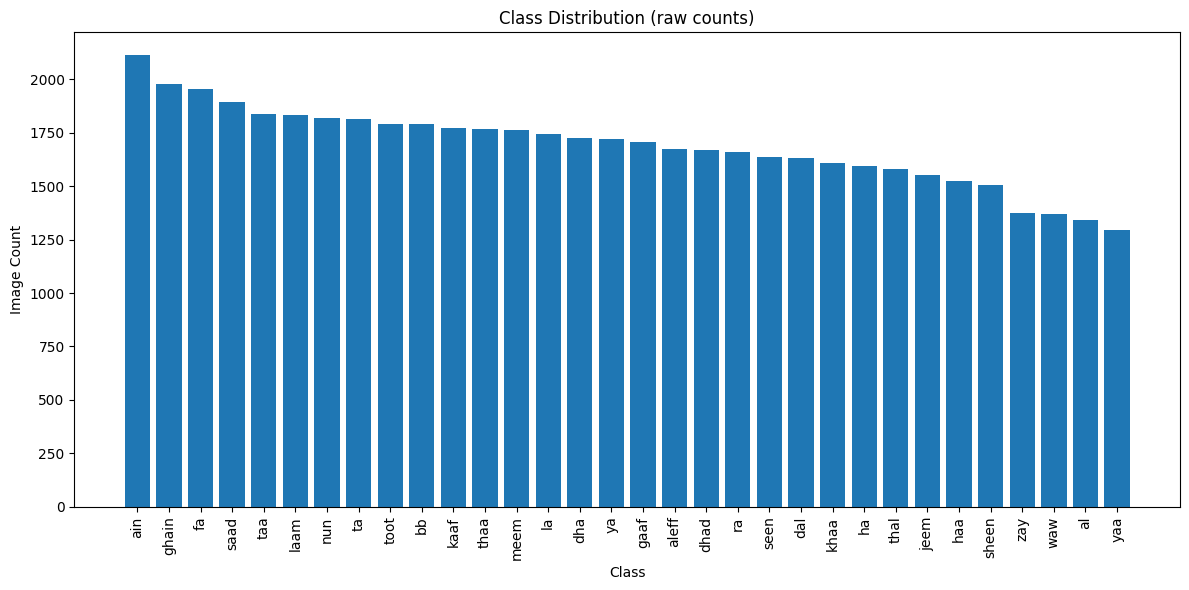

In [37]:
def count_images_per_class(classes):
    rows = []
    for c in tqdm(classes, desc="Counting images per class"):
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
    return df

df_counts = count_images_per_class(classes)
display(df_counts)
report_table("Class Counts", df_counts, "class_counts.csv", show_rows=len(df_counts))

df_sorted = df_counts.sort_values("count", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
plt.bar(df_sorted["class"], df_sorted["count"])
plt.xticks(rotation=90)
plt.title("Class Distribution (raw counts)")
plt.xlabel("Class"); plt.ylabel("Image Count")
bar_path = OUTPUT_DIR / "class_distribution.png"
savefig_and_show(bar_path)
report_image("Class Distribution (bar)", bar_path)

ADD PERCENTAGES + PIE

,class,count,percentage
0,ain,2114,3.911266
1,ghain,1977,3.657792
2,fa,1955,3.617088
3,saad,1895,3.506078
4,taa,1838,3.400618
5,laam,1832,3.389517
6,nun,1819,3.365465
7,ta,1816,3.359914
8,toot,1791,3.313660
9,bb,1791,3.313660


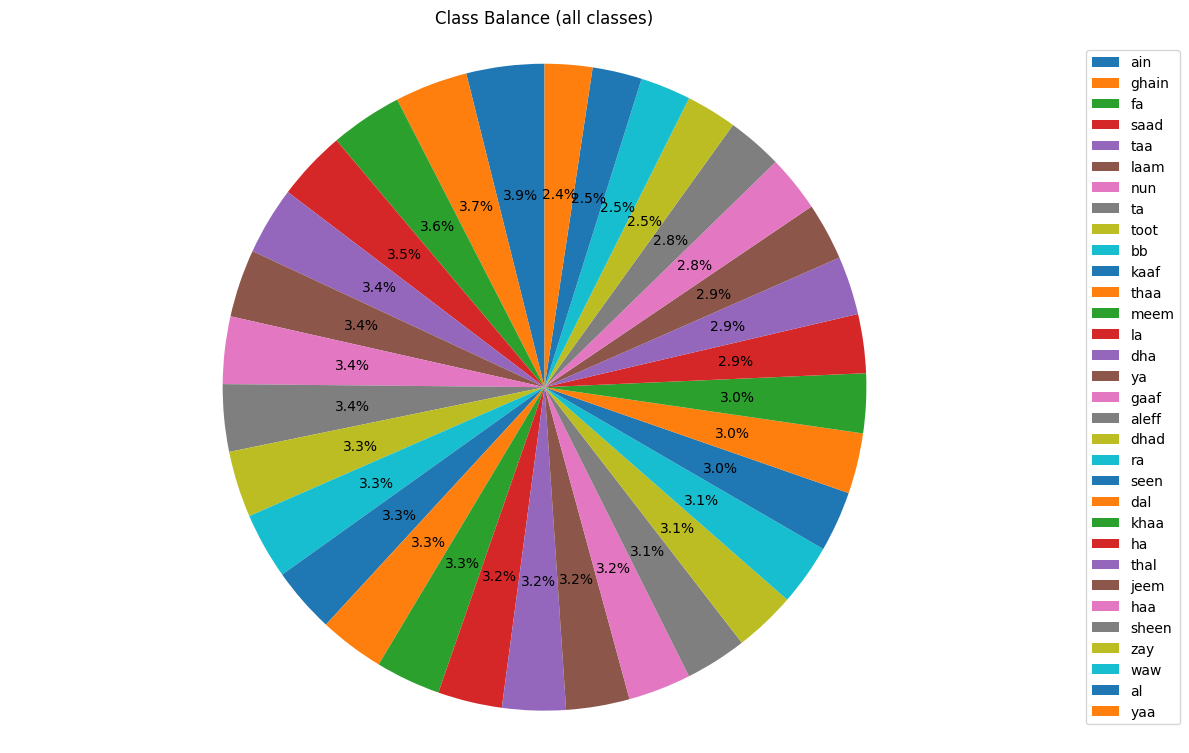

In [38]:
def add_percentages(df_counts: pd.DataFrame):
    total = int(df_counts["count"].sum())
    df2 = df_counts.copy()
    df2["percentage"] = (df2["count"] / total) * 100.0
    df2 = df2.sort_values("count", ascending=False).reset_index(drop=True)
    return df2

df_pct = add_percentages(df_counts)
display(df_pct)
report_table("Class Counts with Percentage", df_pct, "class_counts_with_percentage.csv", show_rows=len(df_pct))

if ENABLE_PIE_CHART:
    plt.figure(figsize=(12,8))
    plt.pie(df_pct["percentage"], autopct="%.1f%%", startangle=90)
    plt.title("Class Balance (all classes)")
    plt.axis('equal')
    plt.legend(df_pct["class"], loc="center left", bbox_to_anchor=(1, 0.5))
    pie_path = OUTPUT_DIR / "class_balance.png"
    savefig_and_show(pie_path)
    report_image("Class Balance (pie)", pie_path)

CORRUPTED IMAGES CHECK

Scanning corrupted images: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


,class,corrupted
0,ain,0
1,al,0
30,yaa,0
29,ya,0
28,waw,0
27,toot,0
26,thal,0
25,thaa,0
24,taa,0
23,ta,0


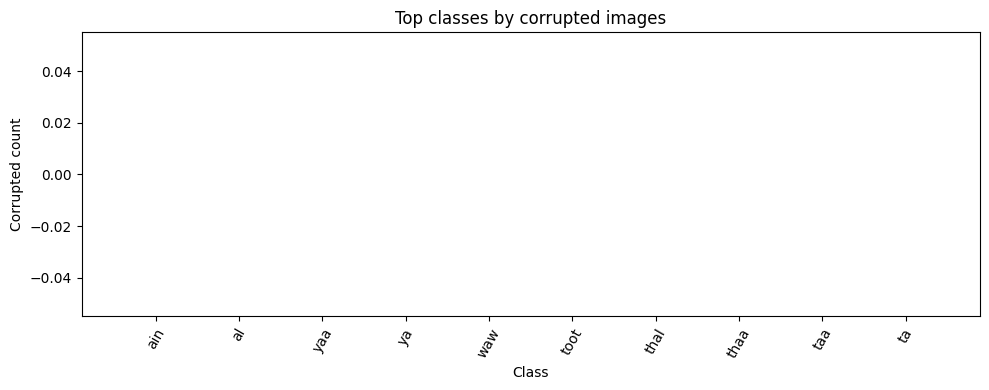

In [39]:
def find_corrupted_images(classes):
    bad_files, per_class = [], []
    for c in tqdm(classes, desc="Scanning corrupted images"):
        bad_in_class = 0
        for p in c.iterdir():
            if not is_image(p):
                continue
            im = safe_imread(p)
            if im is None:
                bad_files.append(str(p))
                bad_in_class += 1
        per_class.append({"class": c.name, "corrupted": bad_in_class})
    df_bad = pd.DataFrame(per_class).sort_values("corrupted", ascending=False)
    if bad_files:
        with open(OUTPUT_DIR / "corrupted_images.json", "w", encoding="utf-8") as f:
            json.dump(bad_files, f, ensure_ascii=False, indent=2)
    return bad_files, df_bad

bad_files, bad_df = find_corrupted_images(classes)
display(bad_df)
report_table("Corrupted Images per Class", bad_df, "corrupted_counts_per_class.csv", show_rows=len(bad_df))
report_section("Corrupted Summary", f"Total corrupted files: **{len(bad_files)}**" + (", saved to `corrupted_images.json`" if bad_files else ""))

# optional top-10 bar
top_bad = bad_df.head(10)
plt.figure(figsize=(10,4))
plt.bar(top_bad["class"], top_bad["corrupted"])
plt.xticks(rotation=60)
plt.title("Top classes by corrupted images")
plt.xlabel("Class"); plt.ylabel("Corrupted count")
corr_path = OUTPUT_DIR / "corrupted_top10.png"
savefig_and_show(corr_path)
report_image("Top classes by corrupted images", corr_path)

RANDOM SAMPLE GRID

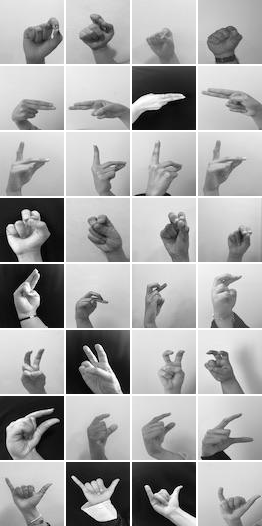

In [40]:
def save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64)):
    try:
        chosen = random.sample(classes, k=min(max_classes, len(classes)))
    except ValueError:
        chosen = classes
    tiles = []
    for c in chosen:
        imgs = [p for p in c.iterdir() if is_image(p)]
        random.shuffle(imgs)
        imgs = imgs[:samples_per_class]
        for p in imgs:
            im = safe_imread(p, flags=cv2.IMREAD_GRAYSCALE)
            if im is None: 
                continue
            im = cv2.resize(im, tile_size, interpolation=cv2.INTER_AREA)
            tiles.append(im)
    if not tiles:
        return None
    rows, cols = max_classes, samples_per_class
    rows = min(rows, int(np.ceil(len(tiles)/max(1, cols))))
    h, w = tile_size
    pad = 2
    grid = np.full((rows*(h+pad)-pad, cols*(w+pad)-pad), 255, dtype=np.uint8)
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(tiles): break
            rh, ch = r*(h+pad), c*(w+pad)
            grid[rh:rh+h, ch:ch+w] = tiles[idx]
            idx += 1
    out_path = OUTPUT_DIR / "sample_grid.png"
    cv2.imwrite(str(out_path), grid)
    return out_path

if ENABLE_SAMPLE_GRID:
    grid_path = save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64))
    if grid_path:
        show_png_file(grid_path)
        report_image("Sample Grid", grid_path)

DUPLICATE CHECK

In [41]:

def find_duplicates_by_hash(classes, limit_per_class=None):
    dup_report, total_dups = {}, 0
    for c in tqdm(classes, desc="Duplicate scan (md5)"):
        files = [p for p in c.iterdir() if is_image(p)]
        if limit_per_class is not None:
            files = files[:limit_per_class]
        seen, dups = {}, []
        for p in files:
            try:
                h = md5_of_file(p)
            except Exception:
                continue
            if h in seen:
                dups.append(str(p))
            else:
                seen[h] = str(p)
        if dups:
            dup_report[c.name] = {"duplicates": dups, "kept_example": next(iter(seen.values()))}
            total_dups += len(dups)
    if dup_report:
        with open(OUTPUT_DIR / "duplicates_by_class.json", "w", encoding="utf-8") as f:
            json.dump(dup_report, f, ensure_ascii=False, indent=2)
    return dup_report, total_dups

dups, total_dups = ({}, 0)
if ENABLE_DUP_CHECK:
    dups, total_dups = find_duplicates_by_hash(classes, limit_per_class=DUP_SCAN_LIMIT_PER_CLASS)

report_section("Duplicates Summary", f"Total duplicate files (scanned): **{total_dups}**" + (" (see `duplicates_by_class.json`)" if total_dups else ""))

if dups:
    df_dups_per_class = (
        pd.DataFrame([{"class": k, "duplicates": len(v["duplicates"])} for k,v in dups.items()])
        .sort_values("duplicates", ascending=False)
        .reset_index(drop=True)
    )
    display(df_dups_per_class)
    report_table("Duplicates per Class", df_dups_per_class, "duplicates_per_class.csv", show_rows=len(df_dups_per_class))
else:
    print("No duplicates detected in the scanned set.")

Duplicate scan (md5): 100%|██████████| 32/32 [00:00<00:00, 33.38it/s]


,class,duplicates
0,ya,206
1,aleff,199
2,khaa,195
3,saad,193
4,thaa,193
5,taa,193
6,ain,191
7,thal,191
8,dal,191
9,jeem,190


MAIN

In [42]:
# corrupted count (if file exists)
corr_json = OUTPUT_DIR / "corrupted_images.json"
corrupted_count = 0
if corr_json.exists():
    with open(corr_json, encoding="utf-8") as f:
        corrupted_count = len(json.load(f))

summary_md = (
    f"- Classes: **{len(classes)}**\n"
    f"- Total images: **{int(df_counts['count'].sum())}**\n"
    f"- Corrupted files: **{corrupted_count}**\n"
    f"- Duplicates (scanned): **{total_dups}**\n"
    f"- Outputs folder: `{OUTPUT_DIR.name}`\n"
    f"- Report file: `{REPORT_PATH.name}`\n"
)

display(Markdown("## Final Summary\n\n" + summary_md))
report_section("Final Summary", summary_md)

## Final Summary

- Classes: **32**
- Total images: **54049**
- Corrupted files: **0**
- Duplicates (scanned): **5627**
- Outputs folder: `EDA_outputs`
- Report file: `eda_report.md`
